# Disambiguate Reads Summary

Visualizes the proportion of reads filtered to human, mouse, and ambiguous by the `disambiguate` tool. The notebook will output a figure describing these proportions across all replicates from all 30 samples.

In [1]:
import os
import pandas as pd

import plotnine as gg

/home/gway/anaconda3/envs/pdx-exomeseq-analysis/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Load Phenotype Data 
file = 'pdx_phenotype.csv'
pheno_df = pd.read_table(file, sep=',')

# Create variable for ID updating
id_updater = dict(zip([x[0] for x in pheno_df.read_id.str.split('_')],
                      pheno_df.final_id))
id_updater

{'001-F0': '001-F0',
 '001-F5': '001-F5',
 '004-F0': '004-M-F0',
 '004-F5': '004-M-F5',
 '004-primary': '004-M',
 '005-F0': '005-M-F0',
 '005-F5': '005-M-F5',
 '005-primary': '005-M',
 '006-F0': '006-F0',
 '006-F5': '006-F5',
 '008-F0': '008-F0',
 '008-F5': '008-F5',
 '018-F0': '008-M1-F0',
 '018-F5': '008-M1-F5',
 '019-F0': '008-M2-F0',
 '019-F5': '008-M2-F5',
 '029-F0': '029-F0',
 '029-F5': '029-F5',
 '030-F0': '030-F0',
 '030-F5': '030-F5',
 '032-F0': '032-F0',
 '032-F5': '032-F5',
 '040-F0': '040-F0',
 '040-F5': '040-F5',
 'KS25': '008-ORTH-M',
 'KS26': '008-ORTH',
 'KS27': '048-F0',
 'KS28': '048-F5',
 'KS29': '048-M1-F0',
 'KS30': '048-M1-F5'}

In [4]:
summary_dir = os.path.join('results', 'disambiguate_summary')
summary_files = [os.path.join(summary_dir, x) for x in os.listdir(summary_dir)]

In [5]:
summary_list = []
for summary_file in summary_files:
    summary_list.append(pd.read_table(summary_file))

In [6]:
summary_df = pd.concat(summary_list)
summary_df.columns = ['sample', 'human', 'mouse', 'ambiguous']
summary_df = summary_df.assign(base_sample = [id_updater[x[0]] for x in summary_df['sample'].str.split('_')])
summary_df['sample'] = summary_df['sample'].replace(id_updater, regex=True)
summary_df = summary_df.assign(lane = [x[2] for x in summary_df['sample'].str.split('_')])

summary_df.head()

,sample,human,mouse,ambiguous,base_sample,lane
0,008-M1-F0_S3_L001_001,16462539,2197374,40841,008-M1-F0,L001
0,029-F0_S5_L004_001,16018400,4208045,56281,029-F0,L004
0,004-M_S1_L003_001,27982301,15379,74792,004-M,L003
0,004-M-F0_S5_L001_001,11253572,4355275,51383,004-M-F0,L001
0,008-F0_S1_L004_001,20584771,2632022,51011,008-F0,L004


In [7]:
total_reads = summary_df['human'] + summary_df['mouse'] + summary_df['ambiguous']
human_percent = (summary_df['human'] / total_reads) * 100
mouse_percent = (summary_df['mouse'] / total_reads) * 100
ambig_percent = (summary_df['ambiguous'] / total_reads) * 100

summary_df = summary_df.assign(human_percent = human_percent.round(1))
summary_df = summary_df.assign(mouse_percent = mouse_percent.round(1))
summary_df = summary_df.assign(ambig_percent = ambig_percent.round(1))

In [8]:
summary_df.to_csv(os.path.join('results', 'full_disambiguate_summary.tsv'), sep='\t')
summary_df.head()

,sample,human,mouse,ambiguous,base_sample,lane,human_percent,mouse_percent,ambig_percent
0,008-M1-F0_S3_L001_001,16462539,2197374,40841,008-M1-F0,L001,88.0,11.8,0.2
0,029-F0_S5_L004_001,16018400,4208045,56281,029-F0,L004,79.0,20.7,0.3
0,004-M_S1_L003_001,27982301,15379,74792,004-M,L003,99.7,0.1,0.3
0,004-M-F0_S5_L001_001,11253572,4355275,51383,004-M-F0,L001,71.9,27.8,0.3
0,008-F0_S1_L004_001,20584771,2632022,51011,008-F0,L004,88.5,11.3,0.2


In [9]:
summary_melt_df = summary_df.melt(id_vars=['base_sample', 'lane', 'sample', 'human_percent',
                                           'mouse_percent', 'ambig_percent'],
                                  value_vars=['human', 'mouse', 'ambiguous'],
                                  var_name='species', value_name='pairs')
summary_melt_df.head()

,base_sample,lane,sample,human_percent,mouse_percent,ambig_percent,species,pairs
0,008-M1-F0,L001,008-M1-F0_S3_L001_001,88.0,11.8,0.2,human,16462539
1,029-F0,L004,029-F0_S5_L004_001,79.0,20.7,0.3,human,16018400
2,004-M,L003,004-M_S1_L003_001,99.7,0.1,0.3,human,27982301
3,004-M-F0,L001,004-M-F0_S5_L001_001,71.9,27.8,0.3,human,11253572
4,008-F0,L004,008-F0_S1_L004_001,88.5,11.3,0.2,human,20584771


In [10]:
summary_melt_df.loc[summary_melt_df['species'] != 'human', 'human_percent'] = ''
summary_melt_df.loc[summary_melt_df['species'] != 'mouse', 'mouse_percent'] = ''
summary_melt_df.loc[summary_melt_df['species'] != 'ambiguous', 'ambig_percent'] = ''

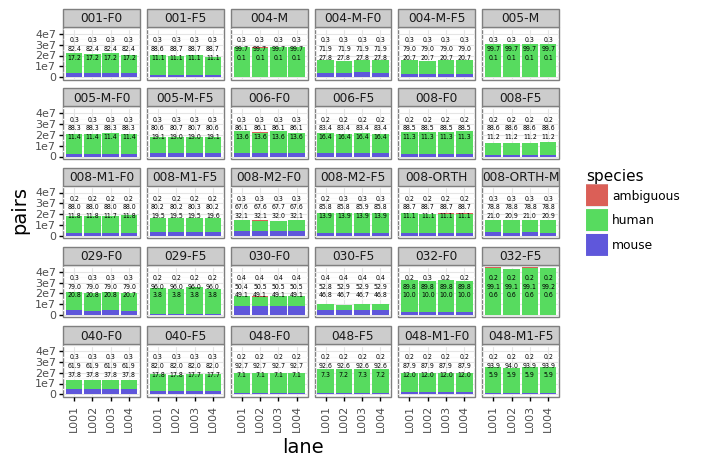

<ggplot: (8793615161650)>

In [11]:
p = (
    gg.ggplot(summary_melt_df, gg.aes(x='lane', y='pairs', fill='species')) +
    gg.geom_bar(stat='identity', position='stack') +
    gg.geom_text(gg.aes(y=3.5e7, label='ambig_percent'), size=4.5) +
    gg.geom_text(gg.aes(y=2.7e7, label='human_percent'), size=4.5) +
    gg.geom_text(gg.aes(y=1.9e7, label='mouse_percent'), size=4.5) +
    gg.facet_wrap('~ base_sample') +
    gg.theme_bw() +
    gg.theme(axis_text_x=gg.element_text(angle='90'),
             axis_text=gg.element_text(size=8),
             axis_title=gg.element_text(size=14))
    )
p

In [12]:
figure_file = os.path.join('figures', 'disambiguate_results.pdf')
gg.ggsave(p, figure_file, height=5.5, width=6.5, dpi=500)

/home/gway/anaconda3/envs/pdx-exomeseq-analysis/lib/python3.5/site-packages/plotnine/ggplot.py:688: UserWarning: Saving 6.5 x 5.5 in image.
  from_inches(height, units), units))
/home/gway/anaconda3/envs/pdx-exomeseq-analysis/lib/python3.5/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: figures/disambiguate_results.pdf
  warn('Filename: {}'.format(filename))
